In [2]:
import re
import requests
import json
import pandas as pd
import urllib

import re
import requests
import json
import pandas as pd
import numpy as np
import os
import nltk
import string
import gensim
from collections import defaultdict

pd.set_option('display.max_colwidth', None)
path = "C://Users//ALESSANDRO//Desktop//Social Graphs and interactions//project//philosophers_pages//"

# Data extraction and preparation

The following project is based on the analysis of *the Network of philosophers*, built up on philosopher data mainly taken from [Wikipedia.com](https://wikipedia.com). From the wiki pages of the philosophers are taken information to build the graphs (nodes and edges), but also additional features that will be used as labels for the entities of the graph, in order to make the analysis more effective. Minor information, in particular quotes written under the posts of users, are taken from [Instagram](https://instagram.com).

## Table of content

1. Download of philosophers pages from Wikipedia
2. scraping of the nationalities of philosophers
3. Scraping of centuries of philosophers
4. Scraping of tag words of philosophers
5. Scraping of topics and fields of research of philosophers
6. scraping of instagram pages of philosophers

## 1. Downloading of the philosophers pages from Wikipedia

The main data source of the notebook is composed by the *corpus* of all the **philosophers pages** of wikipedia. In order to download the philosophers page, a web scraping **API** will be used. The web scraping API that has been developed in order to download the philosophers names and pages is similar to the one used during the course (*Social Graphs and interactions*).

### Parse list of philosophers

[Wikipedia's Lists of philosophers](https://en.wikipedia.org/wiki/Lists_of_philosophers) contains alphabetical lists of all the philosophers. The first step is retrieving the list of names philosophers from these pages, and then discard the philosophers that do not have their individual pages.

In [3]:
# general_link_Philosophers = 'https://en.wikipedia.org/wiki/Lists_of_philosophers'
# link for philosophers' pages: 'https://en.wikipedia.org/wiki/{{ PHILOSOPHER'S NAME }}'

# this is the array with all the wiki pages of the philosophers
list_of_phil = [
                'List of philosophers (A–C)',
                'List of philosophers (D–H)',
                'List of philosophers (I–Q)',
                'List of philosophers (R–Z)'
                ]

# this creates the query to the wiki
def create_query(page_title):
    """Creates a URL to make a query to retrieve content of 
    wikipedia page of the given title

    Parameters
    ----------
    page_title : str
       Title of the page whose content we want to query

    Returns
    ---------
    str
       URL to wikipedia API which can be used for querying content of page with
       given title
    """
    base_url_api = "https://en.wikipedia.org/w/api.php"
    action = "action=query"
    props = "prop=revisions&rvprop=content&rvslots=*"
    dataformat = "format=json"
    titles = "titles=%s" % urllib.parse.quote_plus(page_title.replace(" ", "_"))
    query = "%s?%s&%s&%s&%s" % (base_url_api, action, titles, props, dataformat)
    return query

# this send the query to the api and gets back the text of each page 
def query_wiki_page(query):
    """Makes a query to a wiki page and retrieves its content

    Parameters
    ----------
    page_title : str
       Title of the page whose content we want to query

    Raises
    ---------
    Exception
       If zero or more than 1 page was returned from query

    Returns
    ---------
    (str, bool)
       A tuple containing:
       - Content of the page in wikitext format
       - Boolean value which is true if page exists and false if it is missing

    """
    response = requests.get(query)
    wikidata = response.text
    wikitext = json.loads(wikidata)

    # Make sure `query.pages` contains only one entry. Raise exception otherwise
    pages = wikitext["query"]["pages"]
    if (len(pages) != 1):
        raise Exception("Expected one page, but query returned %d. Double check the page_title." % len(pages))

    # Now that we know that only one page was queried, we can retrieve its number
    page_num = list(pages.keys())[0]

    # If page_num == -1, it means that page does not exists
    if (page_num == "-1"):
      return None, False

    content = pages[page_num]["revisions"][0]["slots"]["main"]["*"]
    return content, True

A regular expression is now used in order to get the philosophers name. The pattern used to match the philosophers names is:

    pattern = "/\/[/\/[(.*?)(?:\|.*?)?\]\] (?:/\/(or.*?\),? )?\/((.*?)\)"

The pattern takes the substrings of the text that is contained between the double bracket `[[ ]]`, and if the bracket contain the symbol `|`, it also takes into account the text that is contained after that symbol

In [4]:
# this uses a regular expression to get the philosopher names, so what exists between `[[ ]]` and in case it has `|` it takes it into consideration as well
def find_phil_names(text):

    # First, remove the top and bottom part of the page which contain other links
    # thank the list of philosophers
    pattern_bottom = "TOC top"
    position_bottom = text.find(pattern_bottom)
    text = text[:position_bottom]

    pattern_top = "=="
    position_top = text.find(pattern_top)
    text = text[position_top:]

    pattern = "\[\[(.*?)(?:\|.*?)?\]\] (?:\(or.*?\),? )?\((.*?)\)"
    matches = re.findall(pattern, text)
    return matches

A list with the philosophers names is built from the query that has been developed. The output of the block of code below is a dataframe with the names of the philosophers, with Birth and death dates.

In [5]:
# here we are creating a list of philosophers' names
list_of_all_phil = []

for i in list_of_phil:
    list_of_all_phil = list_of_all_phil + find_phil_names(query_wiki_page(create_query(i))[0])

# creating a DataFrame and doing some operations on it 
df = pd.DataFrame(list_of_all_phil, columns=['Name', 'Birth/death dates'])
df.drop_duplicates(subset ="Name", inplace = True, ignore_index= True)
df = df.sort_values('Name')
df.reset_index(inplace=True, drop=True)
df.head()

,Name,Birth/death dates
0,Aaron Ben-Ze'ev,born 1949
1,Abd al-Jabiri,born 1935
2,Abd al-Latif al-Baghdadi,1162-1231
3,Abdolkarim Soroush,born 1945
4,Abdullah Laroui,born 1935


### Download the philosophers pages

From the list that has been built, for each philosopher it is scraped the wikipedia page and it is saved in a `.txt` file. In the [GitHub repository](https://github.com/aristofanischionis/PhilosophersPageNotebook) is possible to see and download all the philosophers pages, as well as the `.csv` file with the names of the philosophers.

In [ ]:
import os

non_existing_philosophers = []

# Create a subdirectory where we will store data if it does not exist
philosophers_pages_dir = 'philosophers_pages'
if not os.path.exists(philosophers_pages_dir):
    os.makedirs(philosophers_pages_dir)

def save_philosopher_page(philosopher_name, page_name):
    philosopher_page, exists = query_wiki_page(create_query(page_name))

    if not exists:
        non_existing_philosophers.append(philosopher_name)
    return

    # If page redirects to a different page, save that page instead
    pattern = r"#REDIRECT \[\[(.*?)\]\]"
    page_to_redirect = re.match(pattern, philosopher_page)
    if page_to_redirect:
        save_philosopher_page(philosopher_name, page_to_redirect.groups()[0])
        return
    with open("%s/%s.txt" % (philosophers_pages_dir, philosopher_name.replace(" ", "_").replace("\"", "")), "w", encoding="utf-8") as f:
        f.write(philosopher_page)

    for philosopher in df.loc[:, 'Name']:
        save_philosopher_page(philosopher, philosopher)

save_philosophers_pages()

### Remove philosophers without pages and save to CSV

Before saving the dataset in the file `philosophers.csv`, which is available in the repository [GitHub repository](https://github.com/aristofanischionis/PhilosophersPageNotebook), the philosophers without wikipedia pages will be removed.

In [ ]:
df = df[~df['Name'].isin(non_existing_philosophers)]
df.reset_index(inplace=True, drop=True)
df.to_csv('philosophers.csv', index=False, encoding='utf-8')

## 2. Scraping the nationality of the philosophers

### Motivation

It is well known that some countries have strong traditions related to philosophy. Ancient Grece, as birth place of the philosophy, Italy, Germany have all diofferent cultures and traditions related to the philosophy. Investigating and analyzing the nationality of the philosophers is hence a crucial step in order to have a complete overview of the philosophers. Labelling the phuilosophers based on their nationality will hence help the analysis, in order to understand how philosophers of different nationalities interacted between each other. For instance, it is interesting to visualize how the philosophers from one country are connected between each, but also how they are connected with philosophers of other nationalities. This will show how the different thoughts and cultures intersected between each others.

The analysis about the nationalities of the philosophers will also show interesting information about the relationships between countries in different ages. In fact, normally different currents in countries took place in different ages. The philosophical *trend* took place in the ancient greece and it declined in the first century A.D. It is expected that in the network most of the connections will be with philosophers - for instance - coming from the ancient Rome, or jewish. On the other hand, it is expected to see that french and british philosophers will be connected, since both of them influence each others starting from the age of the Illuminism. 

In order to analyze the information about the *nationalities*, a new dataset should be built. The information will be taken from the introduction page of the philosophers, already scraped in another section of the project. 

When analyzing the introduction pages of the philosophers, it has been noticed that the information about the nationality of a philosopher is contained in almost all the pages of Wikipedia. Therefore, the introduction page will be used also in this section

### Data collection

First, the libraries that are going to be used in this section are uploaded. The path variable is declared and the list of all the philosophers is taken. Moreover, the introduction of each philosopher is extracted from the page, as explained in the section in which the *tagwords* have been extracted

In [6]:
import re
import requests
import json
import pandas as pd
import numpy as np

pd.set_option('display.max_colwidth', None)
path = "C://Users//ALESSANDRO//Desktop//Social Graphs and interactions//project//philosophers_pages//"

philosophers = pd.read_csv(path+"philosophers.csv")

list_of_all_phil = list(philosophers["File name"])
print("Total number of philosofers: ", len(list_of_all_phil))

def take_introduction(list_of_all_phil):
    text = []
    for i in list_of_all_phil:

        file = open(path+i, "r", encoding="utf-8")
        phil_description = file.read()
        pattern_name = "\'\'\'(.*?)\'\'\'(.*?)\n"
        name = re.findall(pattern_name, phil_description)
        text.append(name)
        
#         # split the words into a list
#         T = []
#         for i in text:
#             T.append(i.split())
    return text


text = take_introduction(list_of_all_phil)

Total number of philosofers:  1732


The information scraped so far are then stored in a dataset called `df_intros_nat` 

In [7]:
df_intros_nat = pd.DataFrame()
df_intros_nat["philosopher"] = list_of_all_phil
df_intros_nat["text"] = text

df_intros_nat.head(2)

,philosopher,text
0,Aaron_Ben-Ze'ev.txt,"[(Aaron Ben-Ze'ev, ('''אהרון בן-זאב'''; born 30 July 1949) is an Israeli philosopher. He was President of the [[University of Haifa]] from 2004 to 2012.)]"
1,Abd_al-Latif_al-Baghdadi.txt,"[(ʿAbd al-Laṭīf al-Baghdādī, ({{lang-ar|عبداللطيف البغدادي}}, 1162 [[Baghdad]]–1231 Baghdad), short for '''Muwaffaq al-Dīn Muḥammad ʿAbd al-Laṭīf ibn Yūsuf al-Baghdādī''' ({{lang-ar|موفق الدين محمد عبد اللطيف بن يوسف البغدادي}}), was a [[Islamic medicine|physician]], philosopher, [[Historiography of early Islam|historian]], [[Arabic grammar]]ian and traveler, and one of the most voluminous writers in the [[Near East]] of his time.<ref>[[Chambers Biographical Dictionary]], {{ISBN|0-550-18022-2}}, page 3</ref>)]"


As described in the section `tagwords`, the text is cleaned thanks to the usage of the regular expressions in order to find relevant patterns of text that will not be useful in the extraction of the nationalities.

The process of the usage of the regular expressions is not going to be described here, since it is the same as the *tagwords* section

In [8]:
Text = []
for i in text:
    if i != []:
        Text.append(str(i[0]))
    else:
        Text.append("")

pattern_date = "\((.*?)\)"              # pattern birth date 
pattern_name = "\'\'\'(.*?)\'\'\'"      # pattern name of the philosopher
pattern_ref = "<ref ?(.*?)>(.*?)</ref>" # pattern links
pattern_slash = "\\\'"                  # pattern slashes

pattern_par = "\(|\)"                   # Pattern parenthesis
pattern_virg = "<(.*?)>"                # Pattern quotes

text = []
for i in Text:
    mod = re.sub(pattern_date, "", i)
    mod = re.sub(pattern_name, "", mod)
    mod = re.sub(pattern_ref, "", mod)
    mod = re.sub(pattern_slash, "", mod)
    mod = re.sub(pattern_par, "", mod)
    mod = re.sub(pattern_virg, "", mod)
    text.append(mod)
    
    
pattern_brackets = "\[\[(.*?)\]\]"

Text = []
for i in text:
    mod = re.findall(pattern_brackets, i.lower())

    s = i.lower()
    for j in mod:
        if "|" in j:
            y = j.rpartition('|')[2]
            k = "[["+j+"]]"
            s = s.replace(k, y)
    Text.append(s)
    
    
text = []
for i in Text:
    mod = re.sub("\[|\]", "", i)
    text.append(mod)

In [12]:
df_intros_nat["preprocess_text"] = text

In order to extract the information about the nationalities of the countries, a set object with the most relevant nationalities contained in the dataset has been developed. The set has been written by hand, since it has not found any relevant corpus of  *nationalities*. The reason why it has been decided to consider nationalities instead of countries is that the introduction page of the philosophers (and in general of all the wikipedia pages about people) have the following form:

" *Name of the person* (*Birth place*, *Birth date* - Death place*, *Death date*) is/was a *nationality* *profession* "

Therefore it will be very easy to extract the information about the nationality by matching the nationalities that have been included in the set and the introduction page of the philosopher.

Moreover, the set `nationalities` built, that is displyed in the followign cell, also includes merged nationalities, such as *mericanbritish*, *argentinecanadian*. 

The set has been built by going through the text and finding the relevant names. It has been decided not to use a regular expression in order to extract the nationality name, since it has been noticed that the structure of the text is too different from one philosopher to another, so it would have been quicker and more accurate to take the information by hand.

With the firsts 10 nationalities of the set, it is possible to assign a nationality to the largest part of the dataset. The following nationalities only have less philosophers. The analysis of the distribution of the philosophers in different countries will be done in the following sections.

In [70]:
nationalities = set(["american", "greek", "arabic", "french", "italian", "german", "english",
                     "indian", "chinese", "japanese", "israeli", "iranian", "maroccan", "saudi", 
                     "frenchgerman", "jewish", "egyptian", "hungarian", "persian", "arabian", "hellenistic",
                     "brazilian", "scottish", "germanamerican", "mexican", "arab", "scottishamerican", 
                     "british", "peruvian", "argentine", "russian", "soviet", "australian", "polishamerican",
                     "bielorussian", "bissaguinean", "swedish", "danish", "norwegian", "roman", "zealand",
                     "cyrenaic", "portuguese", "athenian", "swiss", "swissborn", "dutch", "numidian",
                     "lebanese", "polish", "burgundian", "sanskrit", "serbian", "argentinian", "lombard",
                     "genevan", "canadian", "austrian", "czech","norwegianamerican", "americanbritish",
                     "canadianamerican", "african", "georgian", "spanish", "austrian", "finnish", "chilen",
                     "austrianirish", "germanjewish", "austrohungarian", "austrianborn", "francoamerican",
                     "frenchamerican", "italianamerican", "latin", "tibetan", "chineseamerican",
                     "italianjewish", "andalusi", "americanborn", "spanishborn", "korean", "swissfrench",
                     "germandanish", "irish", "flamish", "belgian", "catalan", "hungarianamerican",
                     "armenian", "germanswiss", "czechaustrian", "indian", "venezuelan", "argentinecanadian",
                     "britishamerican", "frenchbrazilian", "croatian", "romanian", "slovenianyugoslavian",
                     "bizantine", "england", "indian", "china", "austrianamerican", "welsh",
                     "zealand-born", "angloirish", "pakistani"])

### Text processing

The text processing phase is conducted in the same way as it has been already done when applying the tf idf model to find the tagwords. The difference in this section is that the nationalities will not be removed from the text, as it has been done in that part.

Therefore, also in this case, the code will not be described in detail, as the block of code is exactly the same as previously.

In [17]:
from sklearn.feature_extraction import stop_words

stopwords = set(stop_words.ENGLISH_STOP_WORDS)
stopwords.add("philosophy")
stopwords.add("philosopher")
stopwords.add("philosophers")


import string
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


def text_processing(text):
    # remove punctuation 
    text = "".join([c for c in text 
                    if c not in string.punctuation])
    # lowercase
    text = "".join([c.lower() for c in text])
    # remove stopwords
    text = " ".join([w for w in text.split() 
                     if w not in stopwords])
    # stemming / lematizing (optional)
    text = " ".join([lemmatizer.lemmatize(w) for w in text.split()])
    return text

import nltk
nltk.download("wordnet")
Text = []
for i in text:
    Text.append(text_processing(i))
    
df_intros_nat["text_clean"] = Text

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ALESSANDRO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
T = []
for i in Text:
    T.append(i.split())
    
df_intros_nat["T"] = T

In [21]:
df_intros_nat.head(2)

,philosopher,text,preprocess_text,text_clean,T
0,Aaron_Ben-Ze'ev.txt,"[(Aaron Ben-Ze'ev, ('''אהרון בן-זאב'''; born 30 July 1949) is an Israeli philosopher. He was President of the [[University of Haifa]] from 2004 to 2012.)]","is an israeli philosopher. he was president of the university of haifa from 2004 to 2012.""",israeli president university haifa 2004 2012,"[israeli, president, university, haifa, 2004, 2012]"
1,Abd_al-Latif_al-Baghdadi.txt,"[(ʿAbd al-Laṭīf al-Baghdādī, ({{lang-ar|عبداللطيف البغدادي}}, 1162 [[Baghdad]]–1231 Baghdad), short for '''Muwaffaq al-Dīn Muḥammad ʿAbd al-Laṭīf ibn Yūsuf al-Baghdādī''' ({{lang-ar|موفق الدين محمد عبد اللطيف بن يوسف البغدادي}}), was a [[Islamic medicine|physician]], philosopher, [[Historiography of early Islam|historian]], [[Arabic grammar]]ian and traveler, and one of the most voluminous writers in the [[Near East]] of his time.<ref>[[Chambers Biographical Dictionary]], {{ISBN|0-550-18022-2}}, page 3</ref>)]",", short for , was a physician, philosopher, historian, arabic grammarian and traveler, and one of the most voluminous writers in the near east of his time.""",short physician historian arabic grammarian traveler voluminous writer near east time,"[short, physician, historian, arabic, grammarian, traveler, voluminous, writer, near, east, time]"


In [27]:
print("The set of nationalities considered includes ", len(nationalities), " elements")

The set of nationalities considered includes  109  elements


The following fuction assign a nationality to each philosopher. The function takes a list of lists containing the split text of each philosopher and it returns a list of strings containing the first nationality belonging to the set `nationalities` that occurs in the texts. If there are matches, the function append an empty string to the list.

Eventually, a column containing the data about the nationalities is add to the dataset `df_intros_nat`.

In [34]:
def assign_nationality(T):

    nationality = []

    for i in T:
        cont = 0
        for c in nationalities:
            if cont == 0:
                if c in i:
                    cont += 1 
                    nationality.append(c)
        if cont == 0:
            nationality.append("")
    return nationality

nationality = assign_nationality(T)

df_intros_nat["nationality"] = nationality

In [38]:
print("The number of philosophers with missing data about the nationality is ", df_intros_nat[df_intros_nat.nationality == ""].shape[0])

The number of philosophers with missing data about the nationality is  244


The dataset is eventually esported to a `.csv` file in order to be used for the data analysis

In [69]:
df_intros_nat.to_csv("C://Users//ALESSANDRO//Desktop//Social Graphs and interactions//project//nationalities.csv")

### Data analysis and statistics

In this last paragraph the distribution of the nationalities will be discussed, in order to figure out how the philosophers are spreaded according to their nationality.

In paricular, a bar char showing the amount of philosophers belonging to each nationality.

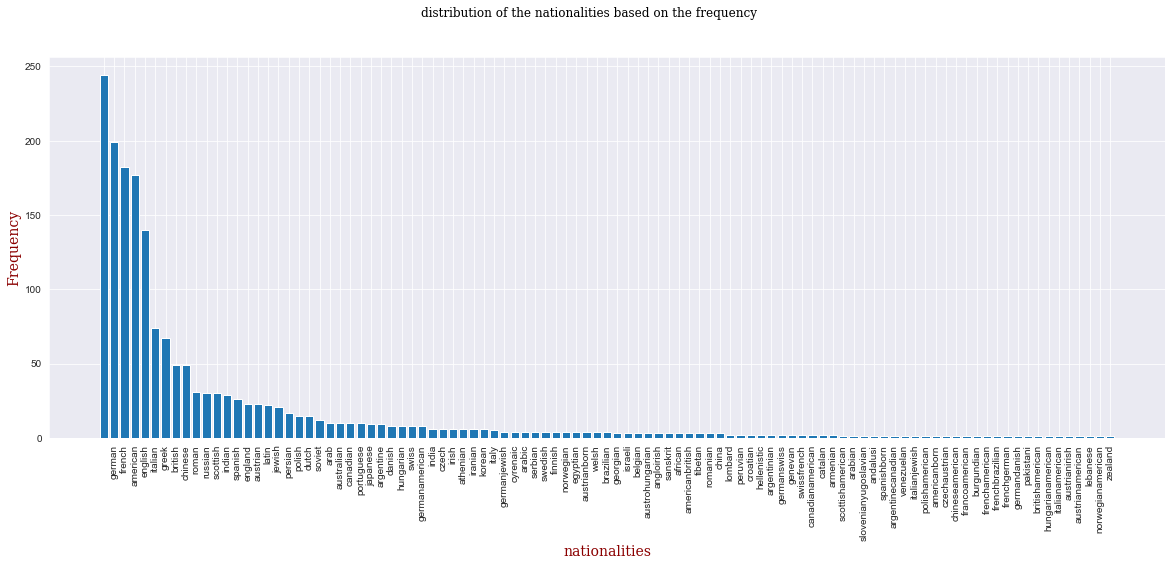

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 14,
        }

font_title = {'family': 'serif',
              'color':  'black',
              'weight': 'normal',
              'size': 50,
            }

fig = plt.figure(figsize=(20, 7))
plt.bar(df_intros_nat.groupby(nationality).count().sort_values("philosopher", ascending = False).index, df_intros_nat.groupby(nationality).count().sort_values("philosopher", ascending = False)["philosopher"])
plt.suptitle("distribution of the nationalities based on the frequency", fontdict=font_title)
plt.xticks(rotation="vertical")
plt.xlabel("nationalities", fontdict=font)
plt.ylabel("Frequency", fontdict=font)
plt.show()

The plot shows how the behavior of the distribution of the nationalities of the philosophers follow somehow the pareto principle. In fact, if we analyze the amount of nationalities and the amount of philosophers we can state that: 

In [89]:
# number of nationalities considered
n_nationalities = len(nationalities)

# number of philosophers in the dataset 
n_philosophers = len(T)

print("The 20% most *populous* nationalities in the dataset is made of ", round(n_nationalities*0.2), " nationalities.")

# twentieth percentile of nationalities distribution
largest_nat = list(df_intros_nat.groupby(nationality).count().sort_values("philosopher", ascending = False).index[:round(n_nationalities*0.2)])

print("")

print("The number of philosophers belonging to the 20% most *populous* nationalities in the dataset : ", df_intros_nat[df_intros_nat.nationality.isin(largest_nat)].shape[0])

print("The 80% of the total number of the nationalities of the dataset is: ", round(n_philosophers*0.8))

The 20% most *populous* nationalities in the dataset is made of  21  nationalities.

The number of philosophers belonging to the 20% most *populous* nationalities in the dataset :  1463
The 80% of the total number of the nationalities of the dataset is:  1386


These lines of code show how the principle of pareto is proved in this context: in fact it is verified that:

**roughly the 80% of the philosophers belong to the 20% of the nationalities**

This principle will be used when building the network that will be used to analyze the distribution of the nationalities of the philosophers, since the network will be restricted to the most significant *nationalities* in order to avoid dispersion of information over an amount too large of categories

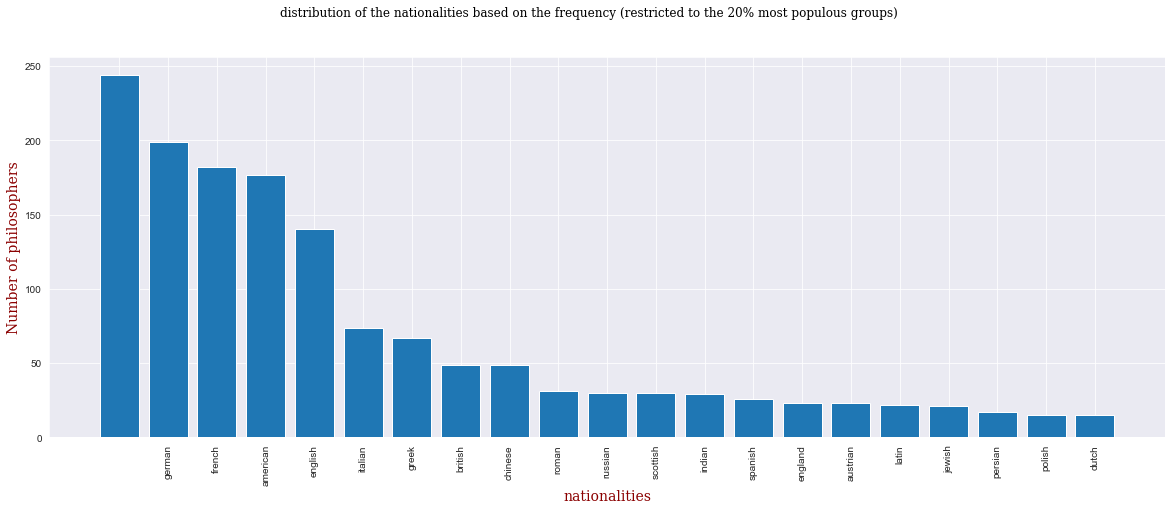

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 14,
        }

font_title = {'family': 'serif',
              'color':  'black',
              'weight': 'normal',
              'size': 50,
            }

fig = plt.figure(figsize=(20, 7))
plt.bar(df_intros_nat.groupby(nationality).count().sort_values("philosopher", ascending = False).index[:21], df_intros_nat.groupby(nationality).count().sort_values("philosopher", ascending = False)["philosopher"][:21])
plt.suptitle("distribution of the nationalities based on the frequency (restricted to the 20% most populous groups)", fontdict=font_title)
plt.xticks(rotation="vertical")
plt.xlabel("nationalities", fontdict=font)
plt.ylabel("Number of philosophers", fontdict=font)
plt.show()

## 3. Scraping of centuries of philosophers

In [ ]:
# philosophers csv get the century of each philosopher
# region of philosopher from the philosopher's pages

In [ ]:
df = pd.read_csv('../philosophers.csv')
print(df["Birth/death dates"])

0       born 1949
1       1162-1231
2       born 1945
3       born 1935
4       1907–1996
          ...    
1727    1904–1977
1728    born 1942
1729    1715–1780
1730    1884–1978
1731      725–788
Name: Birth/death dates, Length: 1732, dtype: object


In [ ]:
def transform_date_to_century(year, isBC):
    year = int(year)
    if year < 1:
        return False
        # and cut the decimal digits
    if isBC:
        return -(int(year / 100) + 1)
    return int(year / 100) + 1

# cases of dates are:
# If it has AD in the title I don't care, if it has BC then I care and I can do (-) in front of century
# If before Christ 
# Xth century
# born ...
# xxx-xxx with other text around maybe
# BC and AD
pattern1 = '(\d+)(st|nd|rd|th) century'
pattern2 = 'born (\d+)'
# if it doesn't match neither of them, then search if it has a number or two
pattern3 = '\d+'
# if one number then that's it transform it to century
# if two numbers then average and transform it to century
philosophers_centuries = []
isBC = False

for date in df["Birth/death dates"]:
    # check if BC
    isBC = False
    if 'BC' in date:
        isBC = True

    century = re.findall(pattern1, date)
    if century:
        century = century[0][0]
        if isBC:
            philosophers_centuries.append(-int(century))
        else:
            philosophers_centuries.append(int(century))
    else:
        year = re.findall(pattern2, date)
        if year:
            year = int(year[0])
            philosophers_centuries.append(transform_date_to_century(year, isBC))
        else:
            year = 0
            # get numbers from string and if two find average if one just use it
            year = re.findall(pattern3, date)
            if len(year) >= 2:
                # here if I have 2 or more numbers then I get first and last element of the list and find average,
                # I could as well just get 0 and 1 elements but there is at least on case where we have 3 numbers in the year list 
                year = (int(year[0]) + int(year[-1]))/2
            elif len(year) == 1:
                year = int(year[0])
            else:
                print("WEIRD case",date)
                year = year[0]

            if year != 0:
                philosophers_centuries.append(transform_date_to_century(year, isBC))

df['century'] = philosophers_centuries

df.to_csv('../philosophers_with_centuries.csv', index=False)

## 4. Scraping of tag words of philosophers

### Motivation

The idea of the following section is to add to the nodes of the network, that are the philosophers, some tagwords that may define or give some information about the philosopher itself. The tagwords are highlited words having the scope of summarize the most significant information about a philosopher. In other words, these words can help to have an idea about the philosopher thoughts, instructions, fields of interest, epoch, and many other information that may be relevant in order to underastand the philosopher in general and it also may explain why a philosopher is linked to another one.

The tagwords for each philosopher are taken from the introduction paragraph of the philosopher. Moreover, the tagwords are taken exploiting the NLP model of TF-IDF (Term frequency - Inverse term frequency), a function that measures the importance of a term in a set of documents. In this case, the set of documents will be the set of the introduction paragraphs of each philosopher.

Adding the tagwords as attributes for the network will also be used when applying a Louvain model, in order to understand and classify relevant clusters of philosophers according to the tagwords associated to each philosopher.

### Data extraction procedure

The following section, therefore will have the aim of building a dataset that assign to each philosopher some tagwords that will eventually used to compute analysis of the graph itself. Note that the amount of tagwords that each philosopher will have depends on the length of the document related to the philosopher, therefore to the importance of the philosopher (usually the more a topic is important, the more its web page will be long).

Starting from the pages of the philosophers previously downloaded and saved in `.txt` files, the dataset containing the philosophers and the related tagwords is built following three steps:
1. Use regular expressions in order to extract from the wikipedia page the introduction and clean the text from the formatting characters, removing not useful information
2. Data cleaning, through text preprocessing (lowercase, lemmatization, stopwords removal, ... )
3. Computation of the TF-IDF model based on the documents available. The top-n words with the highest TF-IDF score will be taken to be used as tagwords. 
4. Assignment of the words to each philosofer in a pandas dataframe

The resulting dataset will be eventually used to complete the networks of the philosophers with relevant attributes.

## Raw text data collection

Each Wikipedia page is composed by a title, an infobox and some paragrahs. Each page has an introductive paragraph, containing the main information related to that page. For the dataset object of this course, that paragraph contains some of the information that show up in the infobox and also some other information, such as the philosophical current, some some topics of interest, style and main works.

First, a list with the names of all the philosofers scraped from wikipedia is loaded. The length of the list `list_of_all_phil` corresponds to the total number of philosofers, that is the amount of nodes that the resulting network will have.

In [3]:
philosophers = pd.read_csv(path+"philosophers.csv")

list_of_all_phil = list(philosophers["File name"])
print("Total number of philosofers: ", len(list_of_all_phil))

Total number of philosofers:  1732


from `.txt` files containing the wikipedia page of the philosofers is taken the introduction thanks to a regular expression, called in the code `pattern_name`. The introduction is saved in a file `name`, and it is add to a list.

In [4]:
def take_introduction(list_of_all_phil):
    
    """
        This function takes a list Wikipedia page titles and it returns
        the raw version of the introduction. It basically extract the 
        introduction of a page, whitouth removing the style and formatting
        attribut that will be kept in the text.
        
        parameters:
        
        list_of_all_phil -> list of wikipedia page titles (in this case, 
        names of philosophers)
        
        returns:
         list of strings, with the introduction paragraph of the philosophers
    
    """
    text = []
    for i in list_of_all_phil:

        file = open(path+i, "r", encoding="utf-8")
        phil_description = file.read()
        pattern_name = "\'\'\'(.*?)\'\'\'(.*?)\n"
        name = re.findall(pattern_name, phil_description)
        text.append(name)
    return text


text = take_introduction(list_of_all_phil)

Hence, the list `text`, contains the introductive paragraph of all the philosophers.

The introduction paragraph is taken exploiting the **regular expressions** (*REGEX*), sequences of symbols that identify a set of strings (src: <Wikipedia.com>). In particular, the regular expression used in this occasion uses the pattern called `pattern_name` to identify the structure of the wikipedia web page in order to take the section of the text belonging to the introduction. In fact, analyzing the web pages downloaded from wikipedia in the `html` format it can be noticed that all of them follow, in general - but with some small differences - the same structure.

The pattern defined in the function:

        pattern_name = "\'\'\'(.*?)\'\'\'(.*?)\n"

takes all the text contained between the three symbols `'`, which in the the philosophers pages consists of the name of the philosopher, and all the information that follow the philosopher name, until the first empty line.

Usually these firsts lines give the most important information about the philosopher, such as the age he/she lived, accademic interest topics, profession and/or the reason why he became famous (e.g. winner of Nobel's Prize). 

It's interesting to notice that this first paragraph contain the information that are needed in order to find the most relevant keywords for the philosopher.
 
The strings of text extracted so far are saved in an object `pd.DataFrame`. 

The dataframe has two columns:
* philosophers
* intro pages

In [5]:
df_intros = pd.DataFrame()
df_intros["philosopher"] = list_of_all_phil
df_intros["text"] = text

df_intros.head(3)

,philosopher,text
0,Aaron_Ben-Ze'ev.txt,"[(Aaron Ben-Ze'ev, ('''אהרון בן-זאב'''; born 30 July 1949) is an Israeli philosopher. He was President of the [[University of Haifa]] from 2004 to 2012.)]"
1,Abd_al-Latif_al-Baghdadi.txt,"[(ʿAbd al-Laṭīf al-Baghdādī, ({{lang-ar|عبداللطيف البغدادي}}, 1162 [[Baghdad]]–1231 Baghdad), short for '''Muwaffaq al-Dīn Muḥammad ʿAbd al-Laṭīf ibn Yūsuf al-Baghdādī''' ({{lang-ar|موفق الدين محمد عبد اللطيف بن يوسف البغدادي}}), was a [[Islamic medicine|physician]], philosopher, [[Historiography of early Islam|historian]], [[Arabic grammar]]ian and traveler, and one of the most voluminous writers in the [[Near East]] of his time.<ref>[[Chambers Biographical Dictionary]], {{ISBN|0-550-18022-2}}, page 3</ref>)]"
2,Abdolkarim_Soroush.txt,"[(Abdolkarim Soroush, ({{lang|fa|عبدالكريم سروش}} {{pronunciation|Abdolkarim Soroush from Iran pronunciation.ogg|listen|(}} {{IPA-fa|æbdolkæriːm soruːʃ}}; born '''Hossein Haj Faraj Dabbagh''' (born 1945; {{lang-fa|حسين حاج فرج دباغ}}), is an [[Iran]]ian Islamic thinker, reformer, [[Rumi]] scholar, public intellectual, and a former professor of philosophy at the [[University of Tehran]] and [[Imam Khomeini International University]].<ref>[http://www.iran-newspaper.com/1383/831117/html/horizon.htm Iran Newspaper<!-- Bot generated title -->] {{webarchive |url=https://web.archive.org/web/20090622101917/http://www.iran-newspaper.com/1383/831117/html/horizon.htm |date=June 22, 2009 }}</ref> He is arguably the most influential figure in the [[Religious intellectualism in Iran|religious intellectual movement]] of Iran. Soroush is currently a visiting scholar at the [[University of Maryland]] in College Park, Maryland. He was also affiliated with other institutions, including Harvard, Princeton, Yale, Columbia, the Leiden-based International Institute as a visiting professor<ref>{{Cite web|url=https://www.loc.gov/today/pr/2009/09-184.html|title=Iranian Philosopher Abdolkarim Soroush Named Distinguished Visiting Scholar at John W. Kluge Center}}</ref> for the Study of Islam in the Modern World (ISIM) and the Wissenschaftskolleg in Berlin. He was named by ''[[Time (magazine)|Time]]'' magazine as one of the world's 100 most influential people in 2005, and by ''[[Prospect (magazine)|Prospect]]'' magazine as one of the most influential intellectuals in the world in 2008.<ref>[https://www.loc.gov/today/pr/2009/09-184.html Library of Congress]</ref> Soroush's ideas, founded on [[relativism]], prompted both supporters and critics to compare his role in reforming Islam to that of [[Martin Luther]] in reforming Christianity.<ref>[https://books.google.com/books?id=E6H6GAzdrXcC&pg=PA297&dq=Soroush+Luther&hl=en&ei=3pwYTaLkGYTwsgaI2OSFDQ&sa=X&oi=book_result&ct=result&resnum=4&ved=0CDEQ6AEwAw#v=onepage&q=Soroush%20Luther&f=false Middle East Contemporary Survey&nbsp;... - Google Books<!-- Bot generated title -->]</ref><ref>[https://books.google.com/books?id=yU3uAAAAMAAJ&q=Soroush+Luther&dq=Soroush+Luther&hl=en&ei=3pwYTaLkGYTwsgaI2OSFDQ&sa=X&oi=book_result&ct=result&resnum=1&ved=0CCMQ6AEwAA An introduction to Islam - Google Books<!-- Bot generated title -->]</ref>)]"


As it can be seen, the data extracted still need some data cleaning before applying the models to extract the most relevant keywords.



The datacleaning will be done in two different steps:

1. The first step consists of finding regular expressions in order to clean the html code. This means removing the html **tags** and other hypertextual information from the text.
2. The second part consist of classic text preprocessing (i.e. remove punctuation, lowercase, remove stopwords, lemmatizing, etc...)


In this first phase, all the hypertextual `html` are substituted with an empty string. This is done since all the information contained in the tags are not useful for the porpouse of finfing the most relevant words in the text. In other words, all these information are not useful for the scope.

Scrolling the `.txt` files of some of the philosophers, it can be seen that the tags inside the pages are pretty much the same for all the philosophers. This means that each page has the same expressions and the same patterns:

* The dates (birth/death dates) are contained in parenthesys. In this section of the work, the date will not be considered. The ages and the historical component of the data will be taken into account in another section of the project.
* As already mentione, the name is contained inside three characters `'`. From now on, the name will be removed from the text, since it is already included in another column of the dataset. Keeping the name of the philosopher inside the text would be redoundant, sn it may affect the developement of the TFIDF. 
* All the hypertextual links are contained in the html tags <ref \*some_text><\ref>. All the hypertextual links are not relevant, and they can be removed from the text.
* Slashes are removed from the text.

Eventually, in order to semplify the process of data mining, all the information contained in parenthesis and quotes are removed. It is assumed that these information are not relevant in the process of finding the most relevant words for each philosopher.

In [6]:
Text = []
for i in text:
    if i != []:
        Text.append(str(i[0]))
    else:
        Text.append("")

pattern_date = "\((.*?)\)"              # pattern birth date 
pattern_name = "\'\'\'(.*?)\'\'\'"      # pattern name of the philosopher
pattern_ref = "<ref ?(.*?)>(.*?)</ref>" # pattern links
pattern_slash = "\\\'"                  # pattern slashes

pattern_par = "\(|\)"                   # Pattern parenthesis
pattern_virg = "<(.*?)>"                # Pattern quotes

text = []
for i in Text:
    mod = re.sub(pattern_date, "", i)
    mod = re.sub(pattern_name, "", mod)
    mod = re.sub(pattern_ref, "", mod)
    mod = re.sub(pattern_slash, "", mod)
    mod = re.sub(pattern_par, "", mod)
    mod = re.sub(pattern_virg, "", mod)
    text.append(mod)
    
    
pattern_brackets = "\[\[(.*?)\]\]"

Text = []
for i in text:
    mod = re.findall(pattern_brackets, i.lower())

    s = i.lower()
    for j in mod:
        if "|" in j:
            y = j.rpartition('|')[2]
            k = "[["+j+"]]"
            s = s.replace(k, y)
    Text.append(s)
    
    
text = []
for i in Text:
    mod = re.sub("\[|\]", "", i)
    text.append(mod)

In [7]:
df_intros["preprocess_text"] = text
df_intros.head(3)

,philosopher,text,preprocess_text
0,Aaron_Ben-Ze'ev.txt,"[(Aaron Ben-Ze'ev, ('''אהרון בן-זאב'''; born 30 July 1949) is an Israeli philosopher. He was President of the [[University of Haifa]] from 2004 to 2012.)]","is an israeli philosopher. he was president of the university of haifa from 2004 to 2012."""
1,Abd_al-Latif_al-Baghdadi.txt,"[(ʿAbd al-Laṭīf al-Baghdādī, ({{lang-ar|عبداللطيف البغدادي}}, 1162 [[Baghdad]]–1231 Baghdad), short for '''Muwaffaq al-Dīn Muḥammad ʿAbd al-Laṭīf ibn Yūsuf al-Baghdādī''' ({{lang-ar|موفق الدين محمد عبد اللطيف بن يوسف البغدادي}}), was a [[Islamic medicine|physician]], philosopher, [[Historiography of early Islam|historian]], [[Arabic grammar]]ian and traveler, and one of the most voluminous writers in the [[Near East]] of his time.<ref>[[Chambers Biographical Dictionary]], {{ISBN|0-550-18022-2}}, page 3</ref>)]",", short for , was a physician, philosopher, historian, arabic grammarian and traveler, and one of the most voluminous writers in the near east of his time."""
2,Abdolkarim_Soroush.txt,"[(Abdolkarim Soroush, ({{lang|fa|عبدالكريم سروش}} {{pronunciation|Abdolkarim Soroush from Iran pronunciation.ogg|listen|(}} {{IPA-fa|æbdolkæriːm soruːʃ}}; born '''Hossein Haj Faraj Dabbagh''' (born 1945; {{lang-fa|حسين حاج فرج دباغ}}), is an [[Iran]]ian Islamic thinker, reformer, [[Rumi]] scholar, public intellectual, and a former professor of philosophy at the [[University of Tehran]] and [[Imam Khomeini International University]].<ref>[http://www.iran-newspaper.com/1383/831117/html/horizon.htm Iran Newspaper<!-- Bot generated title -->] {{webarchive |url=https://web.archive.org/web/20090622101917/http://www.iran-newspaper.com/1383/831117/html/horizon.htm |date=June 22, 2009 }}</ref> He is arguably the most influential figure in the [[Religious intellectualism in Iran|religious intellectual movement]] of Iran. Soroush is currently a visiting scholar at the [[University of Maryland]] in College Park, Maryland. He was also affiliated with other institutions, including Harvard, Princeton, Yale, Columbia, the Leiden-based International Institute as a visiting professor<ref>{{Cite web|url=https://www.loc.gov/today/pr/2009/09-184.html|title=Iranian Philosopher Abdolkarim Soroush Named Distinguished Visiting Scholar at John W. Kluge Center}}</ref> for the Study of Islam in the Modern World (ISIM) and the Wissenschaftskolleg in Berlin. He was named by ''[[Time (magazine)|Time]]'' magazine as one of the world's 100 most influential people in 2005, and by ''[[Prospect (magazine)|Prospect]]'' magazine as one of the most influential intellectuals in the world in 2008.<ref>[https://www.loc.gov/today/pr/2009/09-184.html Library of Congress]</ref> Soroush's ideas, founded on [[relativism]], prompted both supporters and critics to compare his role in reforming Islam to that of [[Martin Luther]] in reforming Christianity.<ref>[https://books.google.com/books?id=E6H6GAzdrXcC&pg=PA297&dq=Soroush+Luther&hl=en&ei=3pwYTaLkGYTwsgaI2OSFDQ&sa=X&oi=book_result&ct=result&resnum=4&ved=0CDEQ6AEwAw#v=onepage&q=Soroush%20Luther&f=false Middle East Contemporary Survey&nbsp;... - Google Books<!-- Bot generated title -->]</ref><ref>[https://books.google.com/books?id=yU3uAAAAMAAJ&q=Soroush+Luther&dq=Soroush+Luther&hl=en&ei=3pwYTaLkGYTwsgaI2OSFDQ&sa=X&oi=book_result&ct=result&resnum=1&ved=0CCMQ6AEwAA An introduction to Islam - Google Books<!-- Bot generated title -->]</ref>)]",", is an iranian islamic thinker, reformer, rumi scholar, public intellectual, and a former professor of philosophy at the university of tehran and imam khomeini international university. he is arguably the most influential figure in the religious intellectual movement of iran. soroush is currently a visiting scholar at the university of maryland in college park, maryland. he was also affiliated with other institutions, including harvard, princeton, yale, columbia, the leiden-based international institute as a visiting professor for the study of islam in the modern wo

The dataset `df_intros` contains now a new column with the text clean from all the special charachters, tags, html formatting. Most of the information have been therefore cleaned, in terms of contents.

The next step is to clean the text from a grammatical point of view.

### Text preprocessing

The text preprocessing is a phase that consists of cleaning the text, by transforming, standardizing and removing irrelevant terms in order to apply the NLP models in the best possible way. In the following section, the text preprocessing will be computed through the following steps:

1. **Puntuaction removal.** The punctuation removal is used to guarantee that the words are not affected by signs in the text. For instance, the word "*philosopher*" would be considered from the models a different word than "*philosopher.*" and "*philosopher,*". Removing the punctuation, the words would be considered in the same way.

2. **lowercase.** For the same reason as 1., all the letters of the text have to be lowercase.

3. **Lemmatizing**. The process of lemmatizing is quite helpful, since it allows to transform the words of a text in their suffix. This would make the text less clear for humans, however on the other hand it will help the machine handling the data.

4. **Stopwords removal**. This last phase consists of removing all those words that are considered not useful for the text (conjunctions, some adverbs, ...). These words are contained in modules belonging to data cleaning libraries, such as `sklearn` and `nlkt`. 

Some other specific words are added to the set of the built-in stopwords. In particular, the words related to the term root *philosoph-* are not relevant since they are shared by all the philosophers. 

Moreover, after running a couple of times the algorithm of TF-IDF, it came out that some of the top-scored words are nationalities, which are mentioned in almost all the pages. Considered the importance of this attribute in the context, it has been decided to not consider the nationality when findin the tagwords, and analyze the nationality of a philosopher separately. Therefore, a list with the most common nationalities is added to the stopwords list.


All this phase of text processing is implemented with Machine Learning python libraries that allow to easily clean the textual data. In particular, the two libraries used in this section to clean the data are `sklearn` and `nlkt`.

In [8]:
from sklearn.feature_extraction import stop_words

stopwords = set(stop_words.ENGLISH_STOP_WORDS)
stopwords.add("philosophy")
stopwords.add("philosopher")
stopwords.add("philosophers")

# add nationalities
countries = set(["american", "greek", "arabic", "french", "italian", "german", "english", "jewish"])
stopwords = stopwords.union(countries)

C:\Users\ALESSANDRO\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


Eventually, to the preprocessed text, the function `text_preprocessing`, as defined below is applied to the column `preprocess_text` in order to get done with the final preprocessing.

In [9]:
import string
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


def text_processing(text):
    # remove punctuation 
    text = "".join([c for c in text 
                    if c not in string.punctuation])
    # lowercase
    text = "".join([c.lower() for c in text])
    # remove stopwords
    text = " ".join([w for w in text.split() 
                     if w not in stopwords])
    # stemming / lematizing (optional)
    text = " ".join([lemmatizer.lemmatize(w) for w in text.split()])
    return text

import nltk
nltk.download("wordnet")
Text = []
for i in text:
    Text.append(text_processing(i))
    
df_intros["text_clean"] = Text

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ALESSANDRO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In order to be handeled properly, the text is split in lists, in which every word represents an element. This new type is eventually add to the dataset.

In [10]:
T = []
for i in Text:
    T.append(i.split())

df_intros["T"] = T

The final version of the dataset `df_intros` is displayed below. The column `text_clean` contains the text that will be used as an input for the TF-IDF model. 

In [11]:
df_intros.head(2)

,philosopher,text,preprocess_text,text_clean,T
0,Aaron_Ben-Ze'ev.txt,"[(Aaron Ben-Ze'ev, ('''אהרון בן-זאב'''; born 30 July 1949) is an Israeli philosopher. He was President of the [[University of Haifa]] from 2004 to 2012.)]","is an israeli philosopher. he was president of the university of haifa from 2004 to 2012.""",israeli president university haifa 2004 2012,"[israeli, president, university, haifa, 2004, 2012]"
1,Abd_al-Latif_al-Baghdadi.txt,"[(ʿAbd al-Laṭīf al-Baghdādī, ({{lang-ar|عبداللطيف البغدادي}}, 1162 [[Baghdad]]–1231 Baghdad), short for '''Muwaffaq al-Dīn Muḥammad ʿAbd al-Laṭīf ibn Yūsuf al-Baghdādī''' ({{lang-ar|موفق الدين محمد عبد اللطيف بن يوسف البغدادي}}), was a [[Islamic medicine|physician]], philosopher, [[Historiography of early Islam|historian]], [[Arabic grammar]]ian and traveler, and one of the most voluminous writers in the [[Near East]] of his time.<ref>[[Chambers Biographical Dictionary]], {{ISBN|0-550-18022-2}}, page 3</ref>)]",", short for , was a physician, philosopher, historian, arabic grammarian and traveler, and one of the most voluminous writers in the near east of his time.""",short physician historian grammarian traveler voluminous writer near east time,"[short, physician, historian, grammarian, traveler, voluminous, writer, near, east, time]"


### Calculate TF-IDF

The tf-idf is a technique used to find the most relevant words in a set of documents. To be a relevant word according to TF-IDF is not enough for a word to be used frequently in a document. It should be used frequently in a document, but rarely in other document.

Hence, for example, the word *born* is used very often in all the introductions of the philosophers, hence it is not considered an important word for TF-IDF. On the other side, words like *ethics* are used rarely in some pages, so they are considered important words.

The TF-IDF is calculated in two steps:
* TF calculation
* IDF calculation

In [12]:
# remove words that appear only once
frequency = defaultdict(int)
for t in T:
    for token in t:
        frequency[token] += 1

texts = [
    [token for token in t if frequency[token] > 1]
    for t in Text
]

The words are sorted based on the frequency and the first 100 are displayed.

In [13]:
most_frequent = sorted(frequency.keys(), key=lambda x: frequency[x], reverse=True)
print(most_frequent[:100])

['known', 'work', 'university', 'political', 'professor', 'theory', 'theologian', 'school', 'science', 'writer', 'century', 'scholar', 'influential', 'book', 'philosophical', 'best', 'author', 'history', 'social', 'considered', 'figure', 'poet', 'born', 'mathematician', 'founder', 'law', 'early', 'time', 'important', 'historian', 'state', 'life', 'later', 'modern', 'british', 'study', 'critic', 'theorist', 'new', 'wrote', 'year', 'religion', 'literary', 'called', 'member', 'language', 'intellectual', 'contribution', 'thought', 'influence', 'chinese', 'world', 'christian', 'ancient', 'major', 'writing', 'catholic', 'logic', 'ethic', 'published', 'movement', 'leading', 'death', 'psychology', 'father', 'age', 'theology', 'thinker', 'idea', 'field', 'russian', 'development', 'church', 'united', 'oxford', 'tradition', 'college', 'prominent', 'literature', 'moral', 'roman', 'art', 'legal', 'marxist', 'religious', 'logician', 'taught', 'contemporary', 'physician', 'human', 'priest', 'widely',

Then, a corpus is built with a bag of words. Basically, the idea behind the BoW is to transform text data (words) into categorical data, with the aim of discretize the words and allow the model to handle them in the best way.

The `corpus` is a matrix showing the frequency of each word (column) in each document (word). The corpus will be the input of the function `gensim.models.TfidfModel()`, that automatically allow to compute the Tf-idf model.

From the `corpus_tfidf` is possible to extract the results and save them in an ordered format in the dictionary `scores`. The dictionary shows the tfidf score for each word in each document.

The model has been run with the python library `gensim`.

In [14]:
dictionary = gensim.corpora.Dictionary(T)
corpus = [dictionary.doc2bow(t) for t in T]

tfidf = gensim.models.TfidfModel(corpus, id2word=dictionary)
corpus_tfidf = tfidf[corpus]

scores = {}
for doc in corpus_tfidf:
    for id, value in doc:
        word = dictionary.get(id)
        if word not in scores:
            scores[word] = []
        scores[word].append(value)
        
import numpy as np
most_frequent = sorted(frequency.keys(), key=lambda x: frequency[x], reverse=True)
filtered_frequent = [w for w in most_frequent if w in scores and np.max(scores[w]) > 0.15]
top_words = [word for word in filtered_frequent[:200]]

The list `top_words` contains the *n = 200 * most relevant words of the corpus, according to tf_idf. These words will be composing the *tagwords* to be added to the dataset.

The *tagwords* are now going to be added to the dataset in a new column. The column `tag` will contain, for each row, a list of tagwords for each philosopher. It is clear that since the tawords are taken among those with a general score that is high, they will vary: some of the philosophers may have more than one tagword, some other may not have tags.

Note that it have been decided to take a fixed amount of tagwords over the whole corpus and not a fixed number of tagwords for each philosopher, in order to being able to cluster the results and avoid a dispersion in the data. In fact, if for each filosopher it would have been decided to take *n* words, the amount of tagwords would have been to large and eventually not relevant for an analysis, such as to cluster philosophers. 

In [15]:
l_tags = []
n_tagwords = []
for i in df_intros.index:
    tags = []
    for word in top_words:
        text = df_intros["preprocess_text"][i]
        if " "+word+" " in " "+text+" ":
            tags.append(word)
    l_tags.append(tags)
    n_tagwords.append(len(tags))
    
df_intros["tag"] = l_tags
df_intros["n_tag"] = n_tagwords

In [16]:
df_intros.head(2)

,philosopher,text,preprocess_text,text_clean,T,tag,n_tag
0,Aaron_Ben-Ze'ev.txt,"[(Aaron Ben-Ze'ev, ('''אהרון בן-זאב'''; born 30 July 1949) is an Israeli philosopher. He was President of the [[University of Haifa]] from 2004 to 2012.)]","is an israeli philosopher. he was president of the university of haifa from 2004 to 2012.""",israeli president university haifa 2004 2012,"[israeli, president, university, haifa, 2004, 2012]","[university, president]",2
1,Abd_al-Latif_al-Baghdadi.txt,"[(ʿAbd al-Laṭīf al-Baghdādī, ({{lang-ar|عبداللطيف البغدادي}}, 1162 [[Baghdad]]–1231 Baghdad), short for '''Muwaffaq al-Dīn Muḥammad ʿAbd al-Laṭīf ibn Yūsuf al-Baghdādī''' ({{lang-ar|موفق الدين محمد عبد اللطيف بن يوسف البغدادي}}), was a [[Islamic medicine|physician]], philosopher, [[Historiography of early Islam|historian]], [[Arabic grammar]]ian and traveler, and one of the most voluminous writers in the [[Near East]] of his time.<ref>[[Chambers Biographical Dictionary]], {{ISBN|0-550-18022-2}}, page 3</ref>)]",", short for , was a physician, philosopher, historian, arabic grammarian and traveler, and one of the most voluminous writers in the near east of his time.""",short physician historian grammarian traveler voluminous writer near east time,"[short, physician, historian, grammarian, traveler, voluminous, writer, near, east, time]",[],0


The final dataset is eventually esported and it will be merged to other dataset, to be included in the networks object of analysis

In [17]:
df_intros.to_csv("C://Users//ALESSANDRO//Desktop//Social Graphs and interactions//project//tagwords.csv")

### Explorative analysis of the tagwords

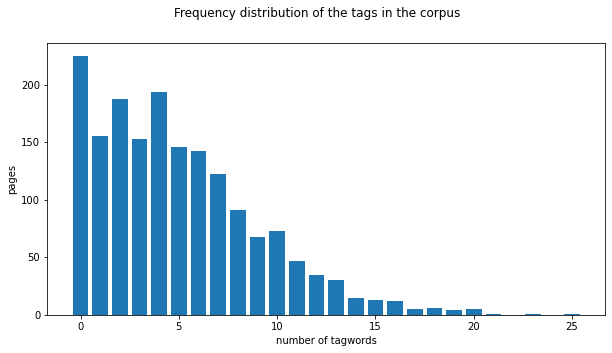

In [80]:
# Find the frequency of the tagwords and compute the number of tags having that frwquency
n_tags = []

for i in l_tags:
    n_tags.append(len(i))

    
elem = []
freq = []

for e in n_tags:
    if e not in elem:
        freq.append(n_tags.count(e))
        elem.append(e)

# Create a dataset with the distribution of the tags for the descriptive statistical analysis
tags_distr = pd.DataFrame()

tags_distr["n_tagwords"] = elem
tags_distr["frequency"] = freq

tags_distr.head()

import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10, 5))
plt.bar(tags_distr["n_tagwords"], tags_distr["frequency"])
fig.suptitle("Frequency distribution of the tags in the corpus")
plt.xlabel("number of tagwords")
plt.ylabel("pages")
plt.show()

The plot shows the distribution of the tagwords in the corpus of the philosopher pages. It can be seen that the most of the philosophers have at leas one tagword. 

225 philosophers have no tagwords related. The number is acceptable, since they are those philosophers with very short introduction page on Wikipedia. Some of these philosophers are shown in the following list.

In [77]:
df_intros[df_intros.n_tag == 0]["philosopher"].head(20)

1                            Abd_al-Latif_al-Baghdadi.txt
10                          Abraham_bar_Hiyya_Ha-Nasi.txt
17                                         Adam_Smith.txt
27                                      Agostino_Nifo.txt
29                                        Akos_Pauler.txt
30                                   Aksapada_Gautama.txt
59                            Alexander_Bryan_Johnson.txt
70                                    Alexandre_Koyre.txt
72                                    Alexius_Meinong.txt
77                        Alfred_Jules_Émile_Fouillée.txt
118    Anthony_Ashley-Cooper,_3rd_Earl_of_Shaftesbury.txt
119                                   Anthony_Collins.txt
129                                  Antoine_Le_Grand.txt
134                                   Antonio_Aliotta.txt
135                                     Antonio_Banfi.txt
154                                    Aron_Gurwitsch.txt
158                              Arthur_Edward_Murphy.txt
161           

The following code shows the number of tagwords for each philosopher, ordered from the largest to the smallest.

In [89]:
tags_distr.sort_values("frequency", ascending=False).head(10)

,n_tagwords,frequency
1,0,225
8,4,194
0,2,188
6,1,155
3,3,153
4,5,146
5,6,142
7,7,122
13,8,91
9,10,73


The largest amount of tags, for one philosopher is displayed below:

In [96]:
print("the philosopher with the largest amount of tagwords has ", max(elem), " words.")

print("there are ", tags_distr[tags_distr.n_tagwords == 25].shape[0], "philosophers having ", max(elem), " tagwords")

df_intros[df_intros.n_tag == 25][["philosopher", "text_clean", "tag", "n_tag"]].head(20)

the philosopher with the largest amount of tagwords has  25  words.
there are  1 philosophers having  25  tagwords


,philosopher,text_clean,tag,n_tag
459,Felix_Ravaisson-Mollien.txt,france influential second half nineteenth century originally remains commonly known félix ravaisson seminal key work l’habitude translated habit ravaissons tradition spiritualism initiated pierre maine biran essay influence habit faculty thinking ravaisson developed doctrine called ‘spiritualist realism’ ‘spiritualist positivism’ according ravaisson scholar mark sinclair thought founding school contingency known influential successor henri bergson tradition seen end 1930s lineage life seen return late twentieth century gilles deleuze ravaisson worked state university late 20 declining position university rennes 1838 employed principle private secretary minister public instruction going secure highranking position inspector general library curator classical antiquity louvre later life appointed president jury aggregation france position considerable influence ravaisson classicist archivist educational administrator painter exhibiting laché,"[known, work, university, school, century, scholar, influential, state, life, later, called, thought, influence, tradition, worked, developed, commonly, public, classical, president, late, essay, minister, doctrine, position]",25


## 5. Scraping of topics and fields of research of philosophers

Topics and categories from philosophers have also been scraped from the wikipedia pages of the philosophers. The Data processing is in the file where the analysis of the categories is computed. The file is called `Final_quotes_notebook.ipynb` that can be found in the [GitHub repository](https://github.com/aristofanischionis/PhilosophersPageNotebook).

## 6. scraping of instagram pages of philosophers

In [ ]:
!apt-get update
!pip install selenium

In [ ]:
#imports here
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
import time
import os

### Download ChromeDriver
Now we need to download latest stable release of ChromeDriver from:
<br>
https://chromedriver.chromium.org/
<br>
### Log In to Your Instagram Account

In [ ]:
#specify the path to chromedriver.exe (download and save on your computer)
driver = webdriver.Chrome("./chromedriver")

#open the webpage
driver.get("https://www.instagram.com/")

#  first click the accept all cookies
cookies_click = WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.XPATH, '//button[contains(text(), "Accept All")]'))).click()

# #target username
username = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "input[name='username']")))
password = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "input[name='password']")))

# #enter username and password
username.clear()
# insert your test username for instagram to be used for the scrapping
username.send_keys("...")
password.clear()
# insert your test password for instagram to be used for the scrapping
password.send_keys("...")

#target the login button and click it
button = WebDriverWait(driver, 2).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button[type='submit']"))).click()

#We are logged in!

In [ ]:
# array of quotes to search 15 now, could be more if needed
array = [
        '#philosophers',
         '#philosophy',
         '#philosophical',
         '#quote', 
         '#quotes', 
         '#motivationalquotes', 
         '#motivational', 
         '#lovequotes', 
         '#quoteoftheday', 
         '#quotestoliveby', 
         '#quotestagram', 
         '#quotesdaily',
         '#quotesaboutlife',
         '#quotesandsayings',
         '#philosophersquotes',
        ]

### Handle Alerts

you might only get a single alert, or you might get 2 of them
<br>
please adjust the cell below accordingly

In [ ]:
# time.sleep(5)
# alert = WebDriverWait(driver, 15).until(EC.element_to_be_clickable((By.XPATH, '//button[contains(text(), "Not Now")]'))).click()
# alert2 = WebDriverWait(driver, 15).until(EC.element_to_be_clickable((By.XPATH, '//button[contains(text(), "Not Now")]'))).click()

### Search for a certain hashtag

In [ ]:
# 2 scrolls cover approx. 35 photos
# 3 scrolls cover approx. 45 photos
path = os.getcwd()
path = os.path.join(path, 'ScrappingInstagramResultsv2/')
if os.path.isdir(path) == False:
    os.mkdir(path)

def search_hashtag(keyword):
    #target the search input field
    searchbox = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, "//input[@placeholder='Search']")))
    searchbox.clear()

    searchbox.send_keys(keyword)

    #FIXING THE DOUBLE ENTER
    time.sleep(5) # Wait for 5 seconds
    my_link = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, "//a[contains(@href, '/" + keyword[1:] + "/')]")))
    my_link.click()
    #increase the range to sroll more
    n_scrolls = 1
    for j in range(0, n_scrolls):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(15)
    #target all the link elements on the page
    
    # try to do it better by extracting the text from images and saving it in a csv as text. Extract it with a regex, the photos have: "this photo may be a text bla bla, so extract this info only and save it in csv"    
    anchors = driver.find_elements_by_tag_name('a')
    anchors = [a.get_attribute('href') for a in anchors]
    #narrow down all links to image links only
    anchors = [a for a in anchors if str(a).startswith("https://www.instagram.com/p/")]

    print('Found ' + str(len(anchors)) + ' links to images')
    
    images = []

    #follow each image link and extract only image at index=1
    for a in anchors:
        driver.get(a)
        time.sleep(4)
        img = driver.find_elements_by_tag_name('img')
        img = [i.get_attribute('alt') for i in img]
        images.append(img[0])
    
    
    filename = path + keyword[1:] + ".txt"
    f = open(filename, "w") 

    for image in images:
        f.write(str(image))
        f.write('\n')

    f.close()

    print("Finished quotes for" + quote)

In [ ]:
# import wget
for quote in array:
    search_hashtag(quote)